### Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

### Load and Explore Data

In [3]:
train_df = pd.read_csv('Dataset/train.csv')

In [4]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [6]:
# Checking for null values
train_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

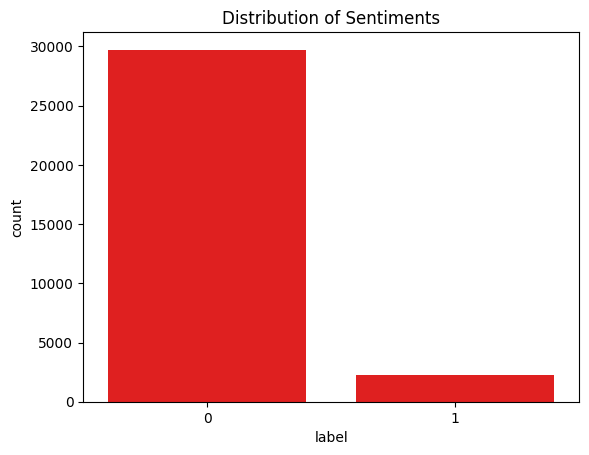

In [8]:
# Plot sentiment distribution
sns.countplot(x='label', data=train_df, color='red')
plt.title('Distribution of Sentiments')
plt.show()

### Data Cleaning and Preprocessing

In [9]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Surya
[nltk_data]     Teja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove links
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

In [11]:
train_df['clean_text'] = train_df['tweet'].apply(clean_text)
train_df.head()

,id,label,tweet,clean_text
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,model love u take u time urð ðððð ððð
4,5,0,factsguide: society now #motivation,factsguide society motivation


### Convert text into features

In [12]:
# Convert cleaned text into TF-IDF feature vectors with a maximum of 8000 features  
vectorizer = TfidfVectorizer(max_features=8000)
X = vectorizer.fit_transform(train_df['clean_text'])
y = train_df['label']

### Train-Test Split

In [13]:
# Split the data into training and testing sets while maintaining label distribution  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Apply SMOTE

In [14]:
# Display class distribution before applying SMOTE  
print("Before SMOTE:\n", y_train.value_counts())

Before SMOTE:
 label
0    23775
1     1794
Name: count, dtype: int64


In [15]:
# Tomek Links (Cleaning the Majority Class)
# - It finds majority class samples (positive reviews) that are very close to minority ones and removes them.
# - This makes the boundary between classes clearer, so the model doesn’t get confused.

# Why Use SMOTE + Tomek Instead of Just SMOTE?
# - SMOTE alone adds new minority samples but doesn’t clean the noise.
# - SMOTE + Tomek not only balances the data but also removes unnecessary majority samples, 
#   making learning more efficient.

from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_train_smote, y_train_smote = smote_tomek.fit_resample(X_train, y_train)

In [16]:
# Display class distribution after applying SMOTE  
print("After SMOTE:\n", y_train_smote.value_counts())

After SMOTE:
 label
0    23775
1    23775
Name: count, dtype: int64


### Model Building

- Logistic Regression

Logistic Regression Accuracy: 0.8986391365556077
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      5945
           1       0.39      0.81      0.53       448

    accuracy                           0.90      6393
   macro avg       0.69      0.86      0.74      6393
weighted avg       0.94      0.90      0.91      6393



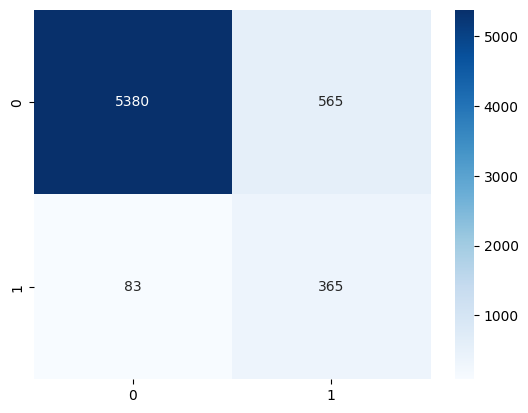

In [17]:
# Train a Logistic Regression model and evaluate its performance  
log_model = LogisticRegression()
log_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set  
y_pred_log = log_model.predict(X_test)

# Print accuracy and classification report  
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# Plot confusion matrix as a heatmap  
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", cmap="Blues")
plt.show()

### Try the Trained model

In [18]:
# Sample text to predict
test_text = "Disgusting service! I will never order from here again."

# Preprocess the text
cleaned_text = clean_text(test_text)  

# Convert text into feature vector using the same vectorizer
z = vectorizer.transform([cleaned_text])  

# Predict using the trained stacking model
y_pred_log = log_model.predict(z)

print("Prediction:", y_pred_log)

Prediction: [1]


### Save the Trained Model

In [19]:
import joblib

# Save the trained log model and the vectorizer
joblib.dump(log_model, "log_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']